In [10]:
import pandas as pd
import numpy as np
import pickle
import glob
import json
import os

from sklearn.utils import shuffle
from keras.preprocessing import sequence, image
from keras.preprocessing.image import load_img, save_img
from keras.preprocessing.image import array_to_img, img_to_array
from keras.models import model_from_json
from keras import backend as K
from collections import Counter
from utils.data_loading.load_data import get_tile_data
from PIL import Image, ImageOps

import matplotlib.pyplot as plt

import pickle5 as pickle
%matplotlib inline

In [11]:
# load the multilabel binarizer
with open("../model/model_tokenizer.pickle", "rb") as handle:
    mlb = pickle.load(handle)
print("Feature Dictionary Loaded")
total_features = len(mlb.classes_)
print("The feature dictionary has size", total_features)
print("Features", mlb.classes_)

# load entire autoencoder architecture
json_file = open("../model/autoencoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
ae_sep_output = model_from_json(loaded_model_json)
ae_sep_output.load_weights("../model/autoencoder_model_test.h5")
print("Loaded Entire Autoencoder Model from the Disk")

# load the encoding architecture and weights
json_file = open("../model/encoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
encoding_model = model_from_json(loaded_model_json)
encoding_model.load_weights("../model/encoder_model_test.h5")
print("Loaded Encoder Model from the Disk")

# load the decoding architecture and weights
json_file = open("../model/decoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
decoding_model = model_from_json(loaded_model_json)
# load weights into new model
decoding_model.load_weights("../model/decoder_model_test.h5")
print("Loaded Decoder Model from the Disk")

Feature Dictionary Loaded
The feature dictionary has size 13
Features ['block' 'breakable' 'climbable' 'collectable' 'element' 'empty' 'hazard'
 'moving' 'openable' 'passable' 'pipe' 'solid' 'wall']
Loaded Entire Autoencoder Model from the Disk
Loaded Encoder Model from the Disk
Loaded Decoder Model from the Disk


In [26]:
def get_image(path):
    img_without_border = load_img(path)
    img = Image.open(path)
    img_with_border = ImageOps.expand(img_without_border, border=16, fill="black")
    return img_without_border, img_with_border

def level_image_unroll(level_array_padded):
    level_image_unrolled = []
    image_h, image_w, image_c = level_array_padded.shape
    for x in range(0, image_w - 32, 16):
        for y in range(0, image_h - 32, 16):
            context_tile = level_array_padded[y : y + 48, x : x + 48, :]
            plt.figure()
            plt.imshow(np.array(context_tile, dtype=np.uint8))
            level_image_unrolled.append(context_tile)
    print(f"Unrolled Level Array Length: {len(level_image_unrolled)}")
    return np.array(level_image_unrolled)

def build_game_dataframe(current_game, game_image_dir, image_extension):
    image_ids = set(
        [
            path.split("/")[-1].split(".")[0]
            for path in glob.glob(game_image_dir + "/*" + image_extension)
        ]
    )
    ids = image_ids
    # build a dataframe
    image_paths = [game_image_dir + image_id + ".png" for image_id in ids]
    game_data = pd.DataFrame(columns=["image_path"])
    game_data["image_path"] = image_paths
    assert game_data.shape[0] == len(ids)
    print("\nAll Levels Loaded")
    print("\nTotal Levels for game ", current_game, " detected are ", len(ids))
    return game_data, list(ids)

def generate_unified_rep(current_game,loaded_game_data,game_image_dir, save_dir):
    
    ptr = 0

    idx2embed_map = {}
    idx2tile_map = {}

    #for idx in range(len(loaded_game_data)):
    for idx in range(1):

        image_path = loaded_game_data.loc[idx]["image_path"]
        level_id = image_path.split("/")[-1].split(".")[0]
        print("\nProcessing level", level_id)
        level_img, level_img_padded = get_image(image_path)
        level_array = img_to_array(level_img)
        level_array_padded = img_to_array(level_img_padded)

        assert level_array.shape[0] % 16 == 0
        assert level_array.shape[1] % 16 == 0
        level_h = level_array.shape[0] / 16
        level_w = level_array.shape[1] / 16
        print("Height ", level_h, "Width ", level_w)
        level_image_expanded = level_image_unroll(level_array_padded)
        print("Expanded level images ", level_image_expanded.shape)

        mapped_text = np.zeros((level_image_expanded.shape[0], 13))
        encoded_level = encoding_model.predict([level_image_expanded, mapped_text])
        print("Encoding dimension", encoded_level.shape)

        for i in range(len(encoded_level)):
            tile_embedding = encoded_level[i]
            tile_sprite = level_image_expanded[i].reshape(48, 48, 3)[
                16 : 16 + 16, 16 : 16 + 16, :
            ]
            idx2embed_map[ptr] = tile_embedding
            idx2tile_map[ptr] = tile_sprite
            ptr += 1

    #     with open(save_dir + level_id + ".pickle", "wb") as handle:
    #         pickle.dump(encoded_level, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #     print("Saved ", level_id, " successfully!")

    # with open(save_dir + "mappings/idx2embed.pickle", "wb") as handle:
    #     pickle.dump(idx2embed_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # print("Index to Embedding map saved successfully!")

    # with open(save_dir + "mappings/idx2tile.pickle", "wb") as handle:
    #     pickle.dump(idx2tile_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # print("Index to Tile map saved successfully!")
    # print("Extracted unified representation for game ",current_game)

In [13]:
current_game = "bubble_bobble"
game_image_dir = "../data/bubble_bobble/"
save_dir = "../data/unified_rep/bubble_bobble/"
loaded_game_data, identifiers = build_game_dataframe(
    current_game,
    game_image_dir,
    ".png")


All Levels Loaded

Total Levels for game  bubble_bobble  detected are  95


In [30]:
with open(save_dir + "mappings/idx2embed.pickle", "rb") as handle:
    a = pickle.load(handle)

In [31]:
a.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [32]:
with open(save_dir + "mappings/idx2tile.pickle", "rb") as handle:
    b = pickle.load(handle)

In [33]:
b.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [35]:
with open(save_dir + "/round03.pickle", "rb") as handle:
    c = pickle.load(handle)

In [37]:
c.shape

(156, 256)


Processing level round64
Height  12.0 Width  13.0


/home/surfytom/.local/share/virtualenvs/TileEmbeddingDissertation-Ir-yPq9b/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Unrolled Level Array Length: 156
Expanded level images  (156, 48, 48, 3)
Encoding dimension (156, 256)
Saved Bubble Bobble Unified Representation!


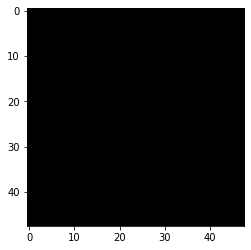

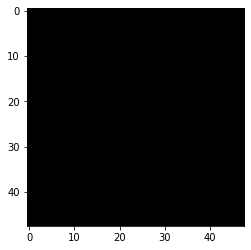

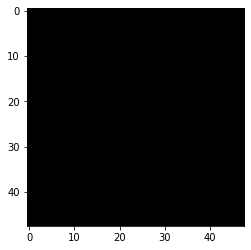

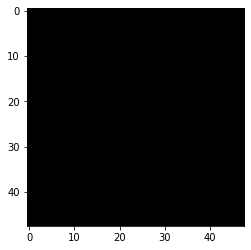

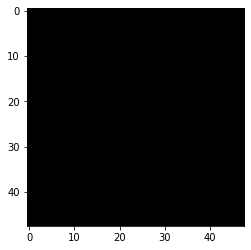

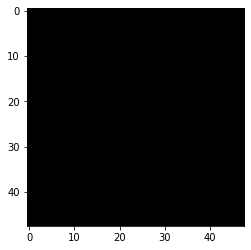

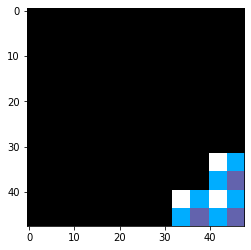

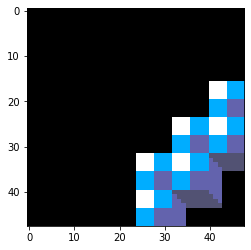

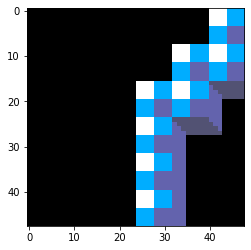

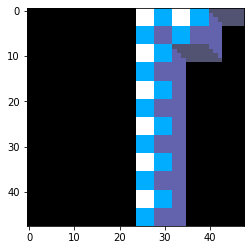

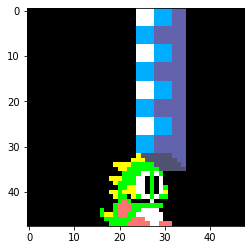

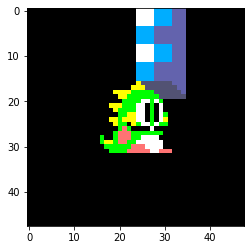

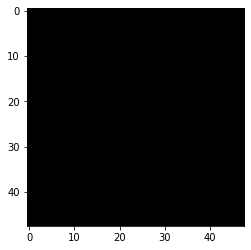

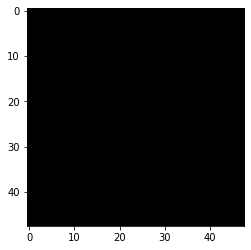

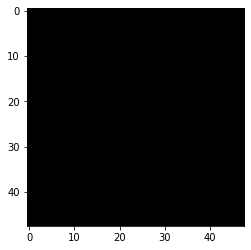

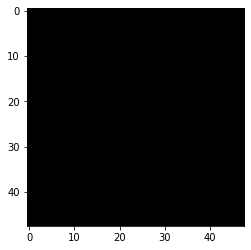

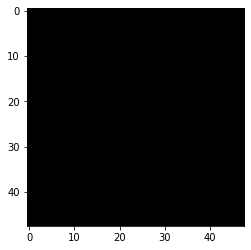

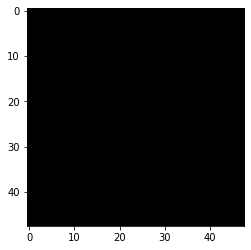

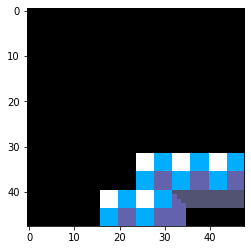

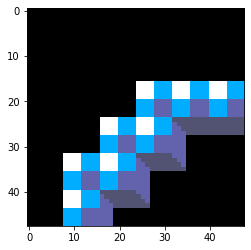

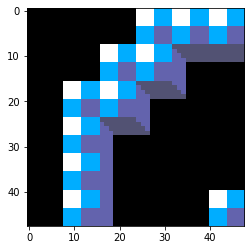

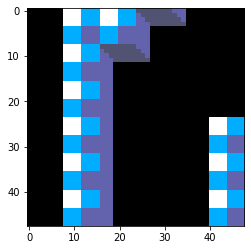

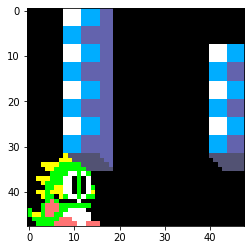

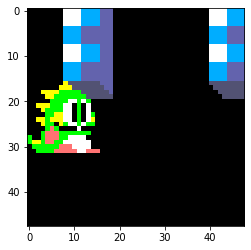

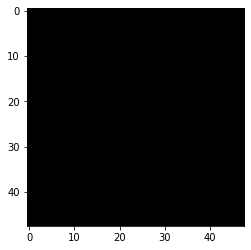

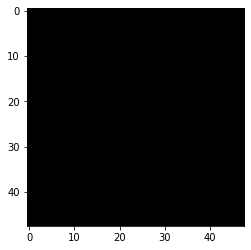

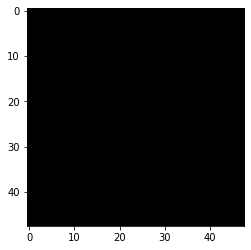

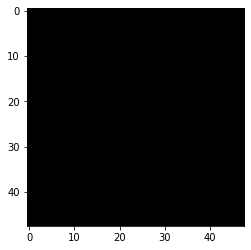

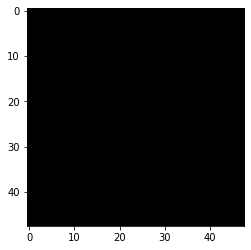

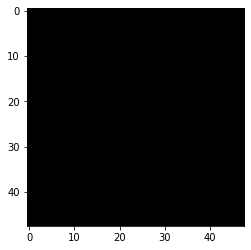

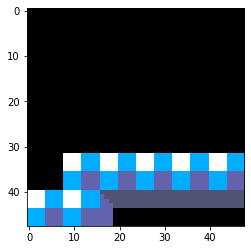

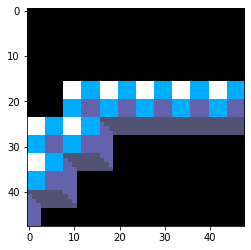

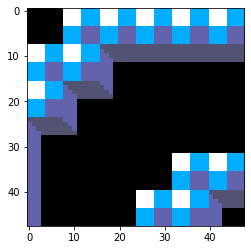

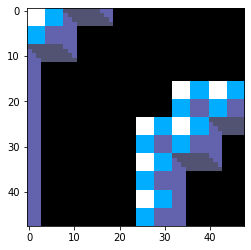

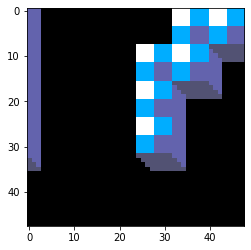

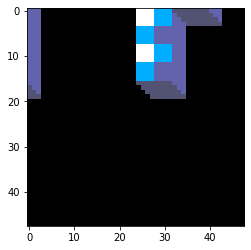

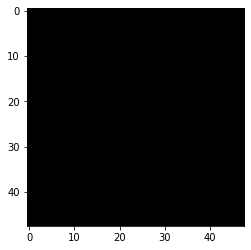

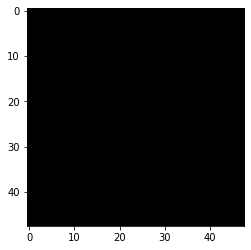

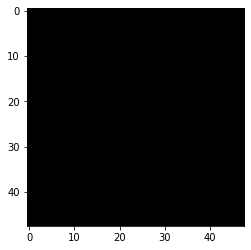

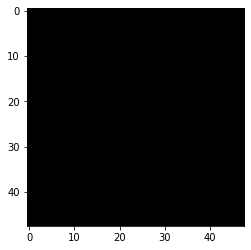

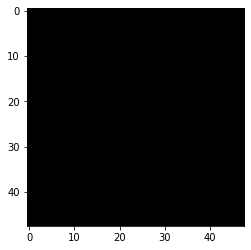

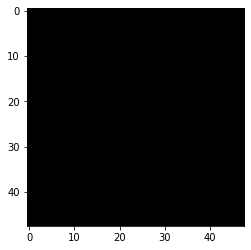

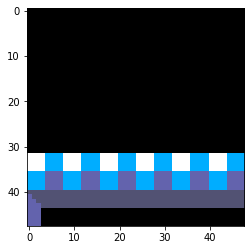

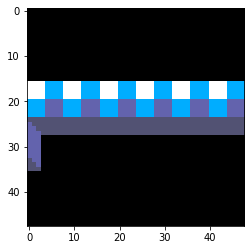

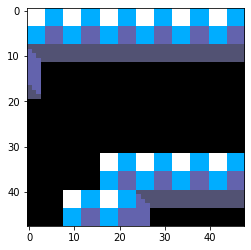

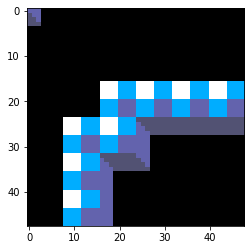

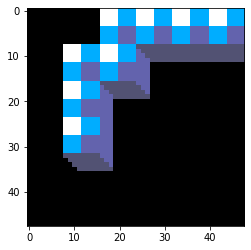

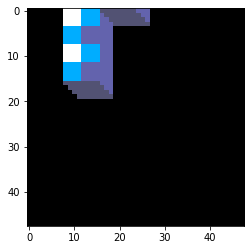

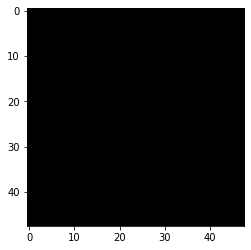

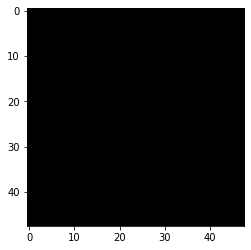

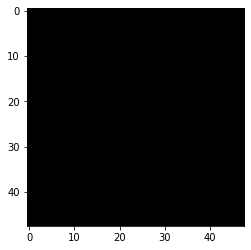

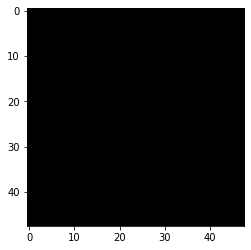

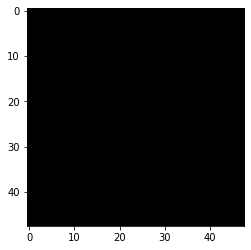

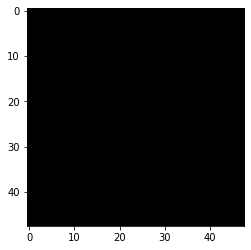

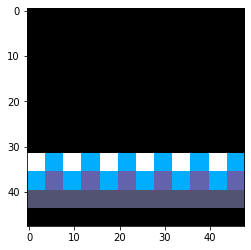

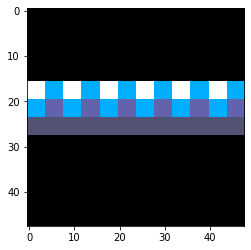

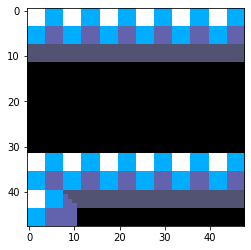

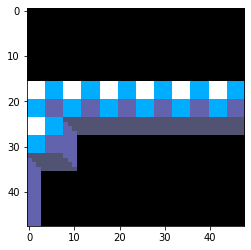

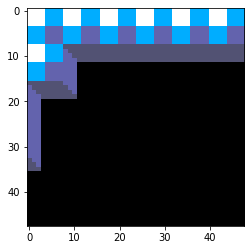

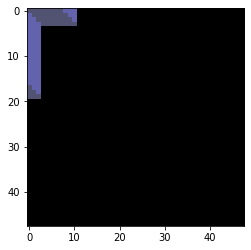

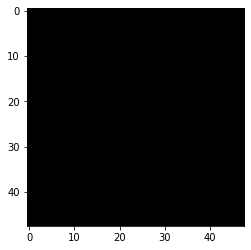

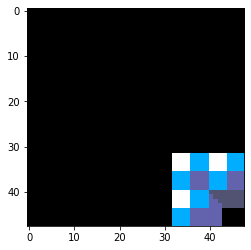

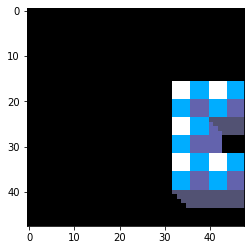

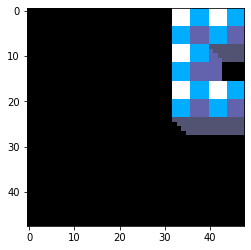

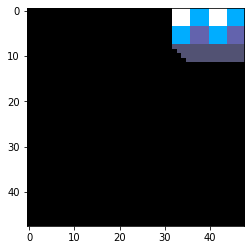

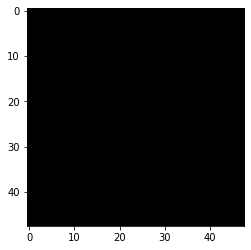

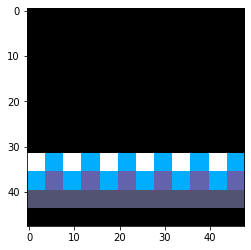

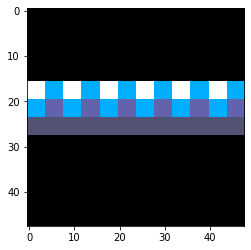

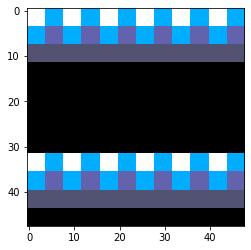

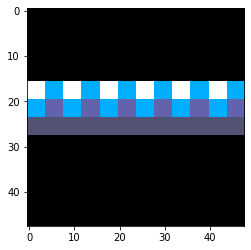

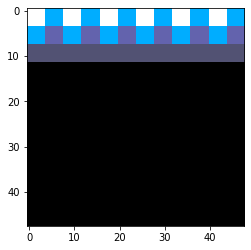

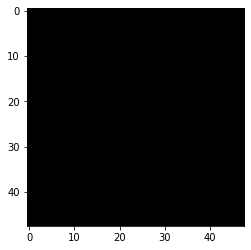

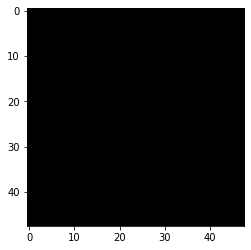

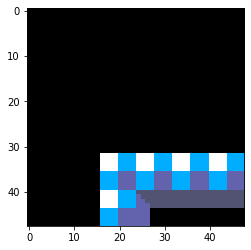

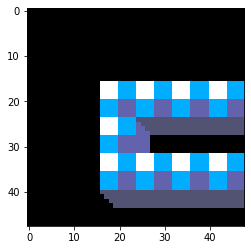

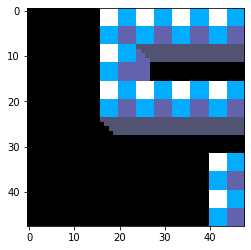

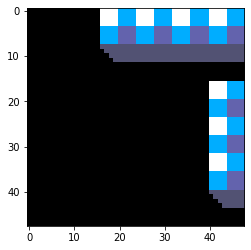

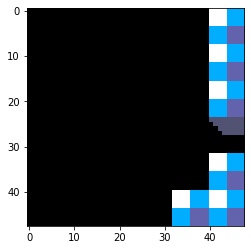

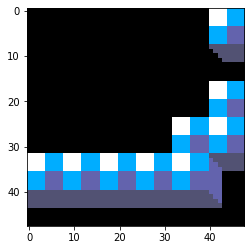

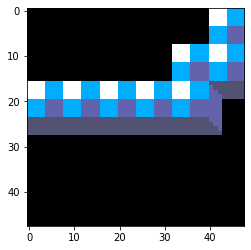

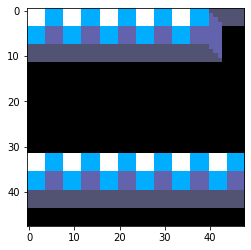

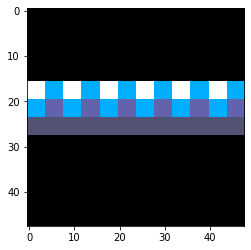

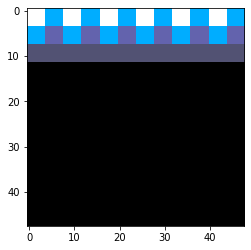

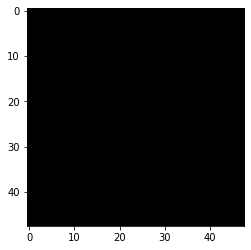

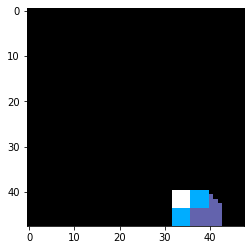

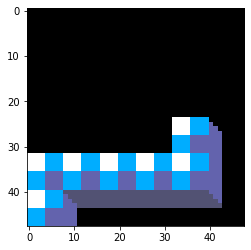

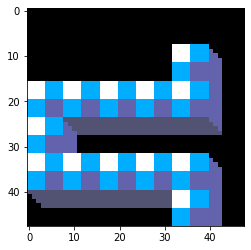

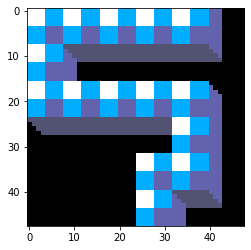

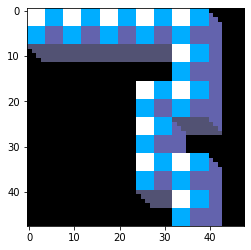

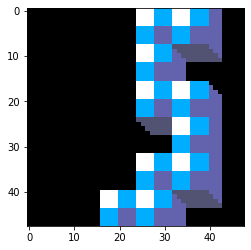

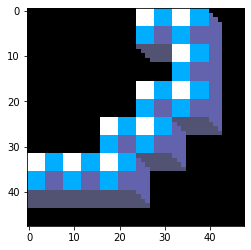

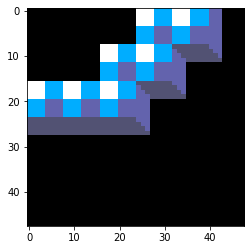

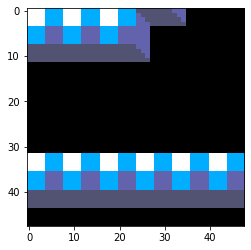

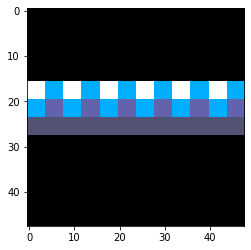

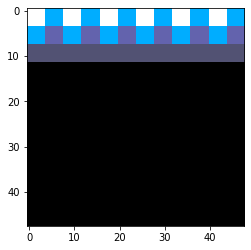

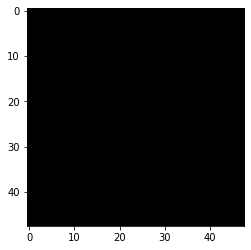

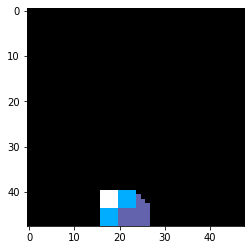

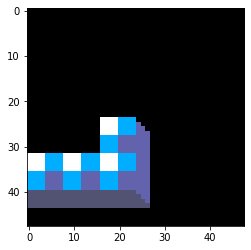

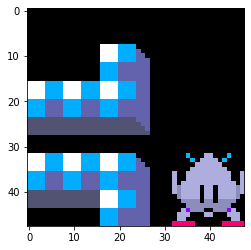

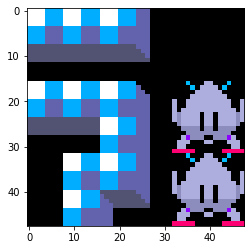

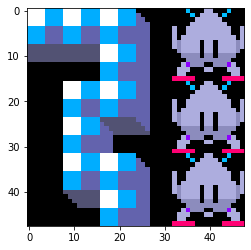

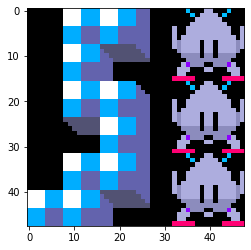

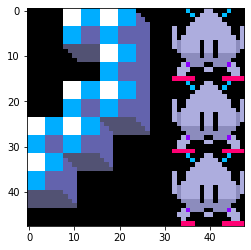

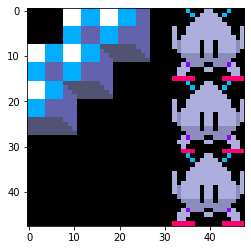

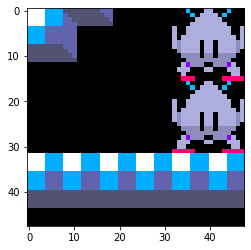

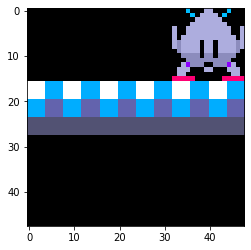

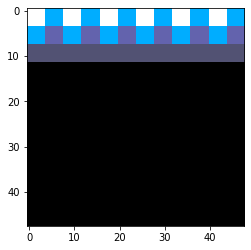

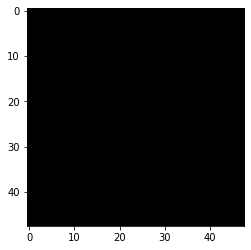

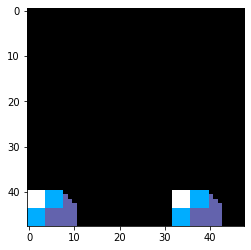

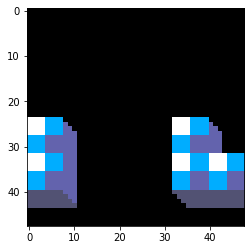

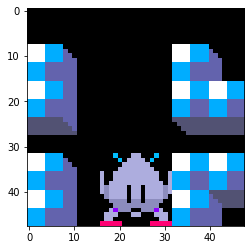

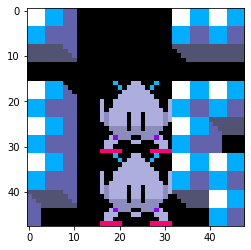

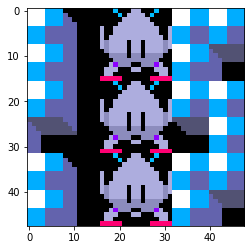

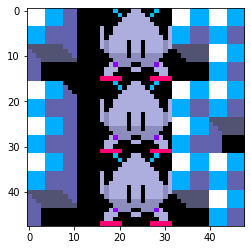

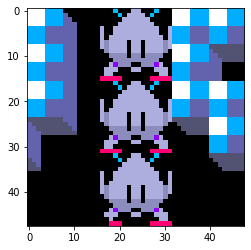

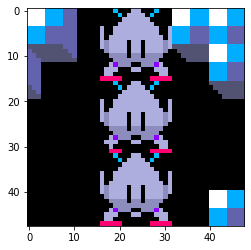

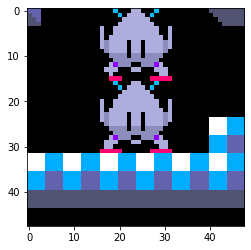

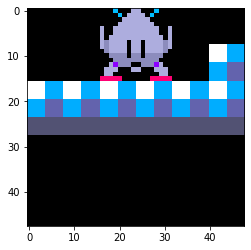

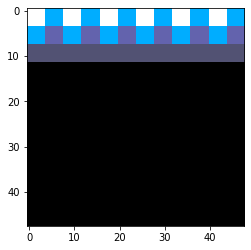

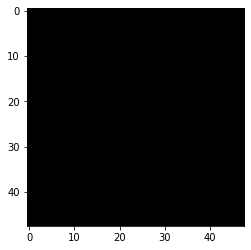

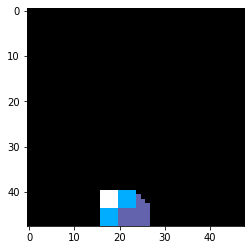

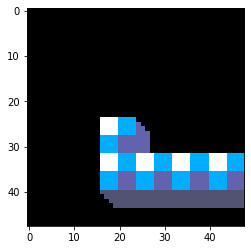

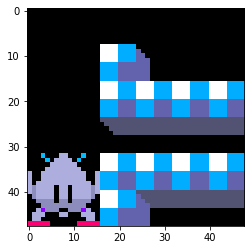

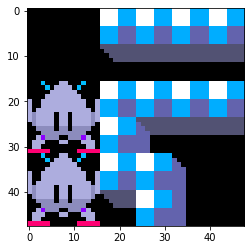

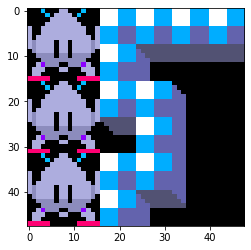

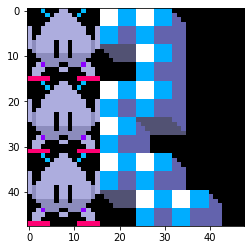

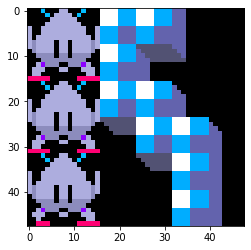

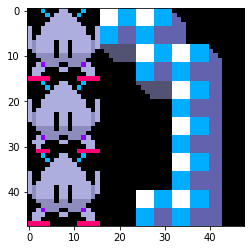

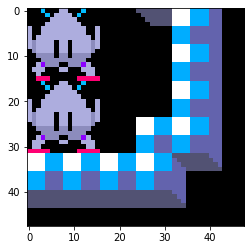

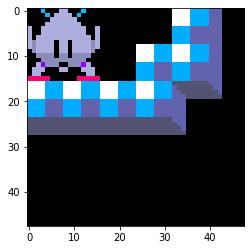

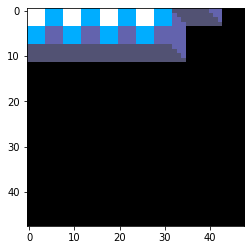

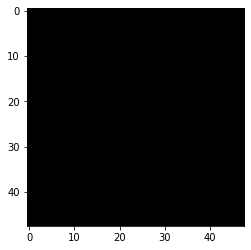

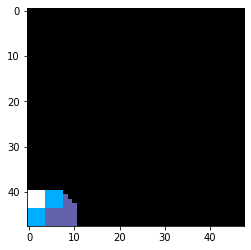

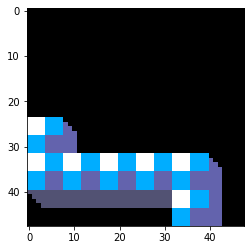

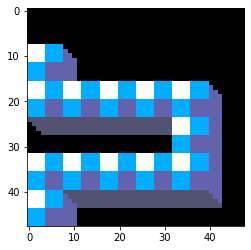

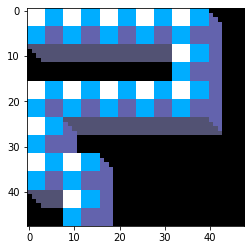

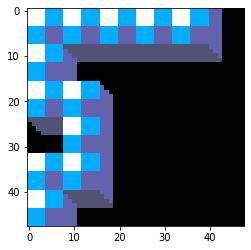

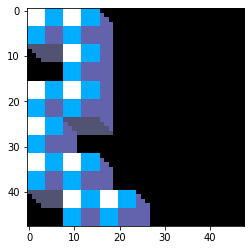

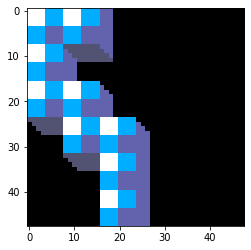

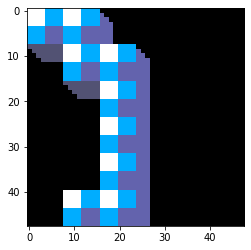

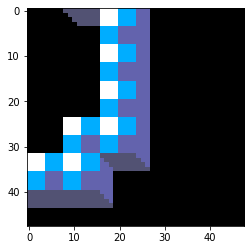

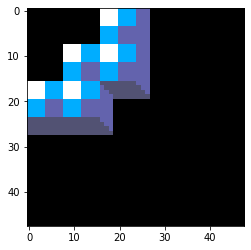

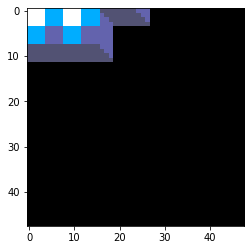

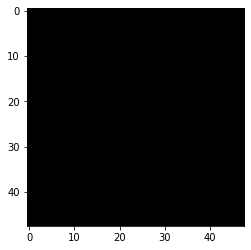

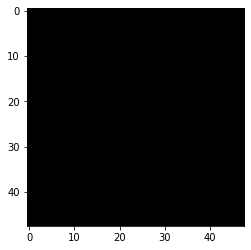

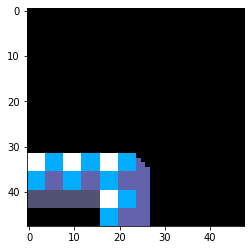

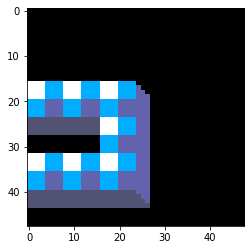

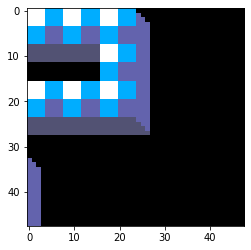

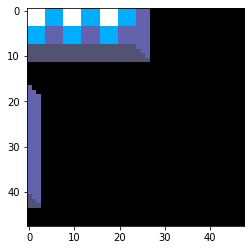

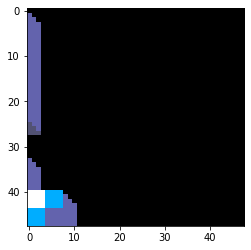

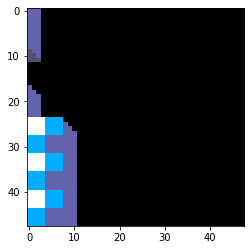

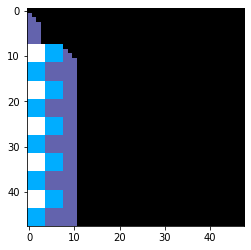

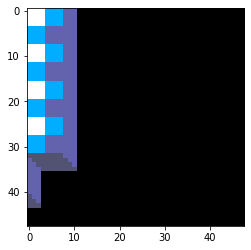

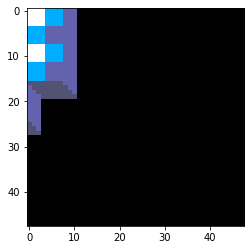

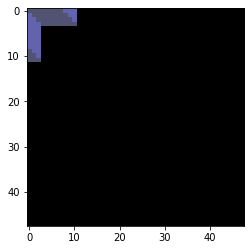

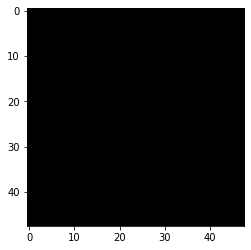

In [27]:
generate_unified_rep(current_game,loaded_game_data,game_image_dir, save_dir)

print("Saved Bubble Bobble Unified Representation!")